# ===============================================================
# TP2 — Taller de Programación (UBA 2025)
# Grupo 4: Ángel Zapata, David Robalino y Federico Kisza
# Docente: María Noelia Romero
# ---------------------------------------------------------------
# Objetivo: Aplicar métodos no supervisados y visualización
# sobre la base EPH Patagónica 2005–2025.
# ==============================================================


# Parte I: Creación de variables, histogramas, kernels y resumen de la base de datos final

In [1371]:
# === 0) Definimos el directorio de manera dinámica ===

from pathlib import Path
import os

# Obtenemos la ruta del notebook actual
notebook_dir = Path().resolve()
print("Directorio actual:", notebook_dir)

# Cambia el directorio de trabajo a esa ruta
os.chdir(notebook_dir)

# Confirmamos el cambio
print("Nuevo directorio de trabajo:", os.getcwd())

Directorio actual: C:\Users\admin\Documents\GitHub\Grupo4_UBA_2025\TP2
Nuevo directorio de trabajo: C:\Users\admin\Documents\GitHub\Grupo4_UBA_2025\TP2


In [1372]:
# === Librerías ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

# Configuración general
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid", palette="deep")

In [1373]:
# === Cargar base del TP1 ===
import os
import pandas as pd

# Ruta actualizada a la carpeta del TP2
DATOS = r"C:\Users\admin\Documents\Códigos Pytohn\UNIDAD 2"
ruta = os.path.join(DATOS, "base_total_patagonica_limpia.csv")

# Cargar base
eph = pd.read_csv(ruta)

# Verificación rápida
print("Base cargada correctamente.")
print("Filas y columnas:", eph.shape)
print("\nVista previa:")
display(eph.head(3))

Base cargada correctamente.
Filas y columnas: (7340, 24)

Vista previa:


,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre
0,1.00,2005,125814,1.00,Varón,46,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,Obrero o empleado,NaN,"2,400.00",480.00,Sí,...un sólo empleo/ocupación/actividad?,"2,400.00","2,400.00",No,46 a 60 años,1.00,3.93,805.93,0
1,2.00,2005,125814,1.00,Mujer,32,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Inactivo,NaN,Ama de casa,"2,400.00",480.00,NaN,NaN,0.00,0.00,NaN,30 a 45 años,0.77,3.93,805.93,0
2,3.00,2005,125814,1.00,Varón,14,Soltero,Obra social (incluye PAMI),Primaria Completa,Inactivo,NaN,Estudiante,"2,400.00",480.00,NaN,NaN,0.00,0.00,NaN,14 años,0.96,3.93,805.93,0


## 1) Creación de la variable edad2 e histogramas

In [1375]:
#Creamos la variable edad2

eph["edad2"] = eph["ch06"] ** 2

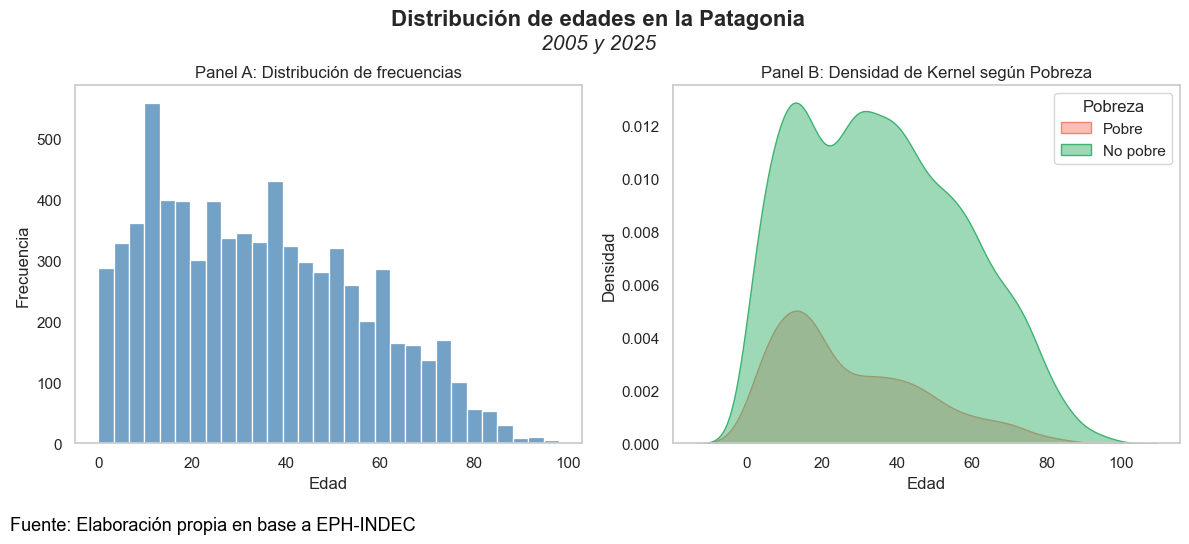

In [1502]:
# === Visualización: Edad ===

fig = plt.figure(figsize=(12,5))

# Panel A: Histograma de edad
plt.subplot(1,2,1)
sns.histplot(eph["ch06"], bins=30, color="steelblue", kde=False)
plt.title("Panel A: Distribución de frecuencias")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.grid(False)

# Panel B: Densidad Kernel por pobreza
plt.subplot(1,2,2)
sns.kdeplot(data=eph, x="ch06", hue="pobre", fill=True,
            palette={0:"mediumseagreen",1:"salmon"}, alpha=0.5)
plt.title("Panel B: Densidad de Kernel según Pobreza")
plt.xlabel("Edad")
plt.grid(False)
plt.ylabel("Densidad")

plt.legend(
    title="Pobreza",
    labels=["Pobre", "No pobre"]
)

plt.suptitle('Distribución de edades en la Patagonia',fontsize=16, fontweight='bold', y=1.0)
plt.figtext(0.5, 0.92, '2005 y 2025',ha='center', fontsize=15, style='italic')
fig.text(0.01, -0.05, 'Fuente: Elaboración propia en base a EPH-INDEC', ha='left', va='bottom', fontsize=13, color='black')

fig.savefig("histograma y kernel de edad.png", dpi=300, bbox_inches="tight")


plt.tight_layout()
plt.show()

## 2) Creación de la variable educ

In [1378]:
#Vuelvo a cargar las EPH crudas para recuperar las nuevas variables solicitadsa: CH12, CH13 Y CH14

#EPH 2025 - La traigo directamente desde la web para ahorrar problema con rutas y llenado de memoria

url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_1_Trim_2025_xls.zip"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Listar los archivos contenidos
    print(z.namelist())
    
    # Abrir el Excel
    with z.open("EPH_usu_1er_Trim_2025_xlsx/usu_individual_T125.xlsx") as f:
        eph_2025 = pd.read_excel(f)

eph_2025.columns = eph_2025.columns.str.lower()

['EPH_usu_1er_Trim_2025_xlsx/', 'EPH_usu_1er_Trim_2025_xlsx/usu_hogar_T125.xlsx', 'EPH_usu_1er_Trim_2025_xlsx/usu_individual_T125.xlsx']


In [1379]:

# Lo mismo para la EPH 2005
url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/t105_dta.zip"

# Descargar el ZIP
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Mostrar los archivos contenidos
    print(z.namelist())

    # Abrir el archivo .dta directamente desde el ZIP
    with z.open("Individual_t105.dta") as f:
        eph_2005 = pd.read_stata(f)

eph_2005.columns = eph_2005.columns.str.lower()

['Hogar_t105.dta', 'Individual_t105.dta', 'T105.txt']


In [1380]:
#Tatamiento de codusu para poder hacer el merge posterior

def norm_key_str(s):
    return (s.astype(str)
             .str.normalize('NFKC')
             .str.replace('\u00a0',' ', regex=False)  # NBSP
             .str.replace(r'\.0$', '', regex=True)     # quita .0 final (p.ej., 125814.0)
             .str.strip())


eph_2005_control = eph_2005.copy()

# Normalizar
cols = ['codusu'] 
for c in cols:
    eph_2005_control[f'{c}_key'] = norm_key_str(eph_2005_control[c])

# Reemplazar las originales con las versiones *_key
for c in cols:
    eph_2005_control[c] = eph_2005_control[f'{c}_key']

# Eliminar las columnas *_key (ya no se necesitan)
eph_2005 = eph_2005_control.drop(columns=[f'{c}_key' for c in cols])


In [1381]:
# Pasamos las variables a numericas CH12, CH13 y CH14 para facilitar tratamiento.

def asistio(ch10):
    if ch10 == 'Sí, asiste':
        return 1
    elif ch10 == 'No asiste, pero asistió':
        return 2
    elif ch10 == 'Nunca asistió':
        return 3
    elif ch10 == 'Ns./Nr.':
        return 9
    else:
        return ch10

eph_2005['ch10'] = eph_2005['ch10'].apply(asistio)


def nivel(ch12):
    if ch12 == 'Jardín/Preescolar':
        return 0
    elif ch12 == 'Primario':
        return 1
    elif ch12 == 'EGB':
        return 3
    elif ch12 == 'Secundario':
        return 4
    elif ch12 == "Polimodal":
        return 5
    elif ch12 == "Terciario":
        return 6
    elif ch12 == "Universitario":
        return 7
    elif ch12 == 'Posgrado Universitario':
        return 8
    elif ch12 == 'Educación especial (discapacitado)':
        return 9
    else:
        return ch12

eph_2005['ch12'] = eph_2005['ch12'].apply(nivel)


def asistio(ch13):
    if ch13 == 'Sí':
        return 1
    elif ch13 == 'No':
        return 2
    elif ch13 == 'Ns./Nr.':
        return 9
    else:
        return ch13

eph_2005['ch13'] = eph_2005['ch13'].apply(asistio)


eph_2005['ch14'] = eph_2005['ch14'].astype(str).str.lstrip('0').replace('', '0')

eph_2005['ch10'] = pd.to_numeric(eph_2005['ch10'], errors='coerce').astype('Int64')
eph_2005['ch12'] = pd.to_numeric(eph_2005['ch12'], errors='coerce').astype('Int64')
eph_2005['ch13'] = pd.to_numeric(eph_2005['ch13'], errors='coerce').astype('Int64')
eph_2005['ch14'] = pd.to_numeric(eph_2005['ch14'], errors='coerce').astype('Int64')
eph_2005['componente'] = pd.to_numeric(eph_2005['componente'], errors='coerce').astype('Int64')
eph_2005['ano4'] = pd.to_numeric(eph_2005['ano4'], errors='coerce').astype('Int64')



In [1382]:
# Me traigo CH12, CH13 y CH14 de esas bases para depsues poder construir años de educación.

eph_2025.columns = eph_2025.columns.str.lower()
eph_2005.columns = eph_2005.columns.str.lower()


variables_interes = ['ano4', 'codusu', 'nro_hogar', 'componente','ch10','ch12', 'ch13', 'ch14']

eph_2025_sub = eph_2025[variables_interes]
eph_2005_sub = eph_2005[variables_interes]

eph_concatenado = (pd.concat([eph_2005_sub, eph_2025_sub], ignore_index=True))


eph = eph.merge(eph_concatenado, on=['ano4','codusu', 'nro_hogar', 'componente'], how='left')

eph.sample(10)

print(eph_2005[['ch10','ch12','ch13','ch14','componente','codusu','nro_hogar','ano4']].dtypes)
print(eph_2005[['ch10','ch12','ch13','ch14','componente','codusu','nro_hogar','ano4']].dtypes)

ch10            Int64
ch12            Int64
ch13            Int64
ch14            Int64
componente      Int64
codusu         object
nro_hogar     float64
ano4            Int64
dtype: object
ch10            Int64
ch12            Int64
ch13            Int64
ch14            Int64
componente      Int64
codusu         object
nro_hogar     float64
ano4            Int64
dtype: object


In [1383]:
# Una vez hecha la limpieza, creamos la variable educ
# Crea la variable 'educ' asignando años equivalentes de educación alcanzados
# según la combinación de nivel (ch12), situación educativa (ch13) y último año aprobado (ch14)
# a partir de las reglas definidas para cada tipo de enseñanza (primaria, secundaria, terciaria, etc.)

eph["educ"] = np.nan

# Lista de reglas
reglas = [
    # Casos base
    ((eph["ch10"] == 3) | (eph["ch06"] < 2) | (eph["ch12"] == 9), 0),

    # Jardín/preescolar
    ((eph["ch13"] == 2) & (eph["ch12"] == 1), 0),

    # Primaria
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 0), 1),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 1), 2),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 2), 3),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 3), 4),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 4), 5),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 5), 6),
    ((eph["ch13"] == 2) & (eph["ch12"] == 2) & (eph["ch14"] == 6), 7),

    # EGB
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 0), 1),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 1), 2),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 2), 3),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 3), 4),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 4), 5),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 5), 6),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 6), 7),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 7), 8),
    ((eph["ch13"] == 2) & (eph["ch12"] == 3) & (eph["ch14"] == 8), 9),

    # Secundaria
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 0), 8),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 1), 9),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 2), 10),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 3), 11),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 4), 12),
    ((eph["ch13"] == 2) & (eph["ch12"] == 4) & (eph["ch14"] == 5), 13),

    # Polimodal
    ((eph["ch13"] == 2) & (eph["ch12"] == 5) & (eph["ch14"] == 0), 10),
    ((eph["ch13"] == 2) & (eph["ch12"] == 5) & (eph["ch14"] == 1), 11),
    ((eph["ch13"] == 2) & (eph["ch12"] == 5) & (eph["ch14"] == 2), 12),
    ((eph["ch13"] == 2) & (eph["ch12"] == 5) & (eph["ch14"] == 3), 13),

    # Terciario
    ((eph["ch13"] == 2) & (eph["ch12"] == 6) & (eph["ch14"] == 0), 13),
    ((eph["ch13"] == 2) & (eph["ch12"] == 6) & (eph["ch14"] == 1), 14),
    ((eph["ch13"] == 2) & (eph["ch12"] == 6) & (eph["ch14"] >= 2) & (eph["ch14"] < 98), 15),

    # Universitario
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 0), 13),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 1), 14),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 2), 15),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 3), 16),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] == 4), 17),
    ((eph["ch13"] == 2) & (eph["ch12"] == 7) & (eph["ch14"] >= 5) & (eph["ch14"] < 98), 18),

    # Posgrado
    ((eph["ch13"] == 2) & (eph["ch12"] == 8) & (eph["ch14"] == 0), 19),
    ((eph["ch13"] == 2) & (eph["ch12"] == 8) & (eph["ch14"] == 1), 20),
    ((eph["ch13"] == 2) & (eph["ch12"] == 8) & (eph["ch14"] == 2), 21),
    ((eph["ch13"] == 2) & (eph["ch12"] == 8) & (eph["ch14"] >= 3) & (eph["ch14"] < 98), 22),

    # Completaron el nivel
    ((eph["ch13"] == 1) & (eph["ch12"] == 1), 1),
    ((eph["ch13"] == 1) & (eph["ch12"] == 2), 8),
    ((eph["ch13"] == 1) & (eph["ch12"] == 3), 11),
    ((eph["ch13"] == 1) & ((eph["ch12"] == 4) | (eph["ch12"] == 5)), 13),
    ((eph["ch13"] == 1) & (eph["ch12"] == 6), 16),
    ((eph["ch13"] == 1) & (eph["ch12"] == 7), 19),
    ((eph["ch13"] == 1) & (eph["ch12"] == 8), 23),
]

# Aplicar todas las reglas 
for condicion, valor in reglas:
    eph.loc[condicion, "educ"] = valor

In [1384]:
#Chequeamos que esté ok

eph[['ch10','ch12','ch13','ch14','nivel_ed']].sample(10)

,ch10,ch12,ch13,ch14,nivel_ed
2521,1,3,2,2.00,Primaria Incompleta (incluye educación especial)
6237,2,4,1,<NA>,Secundaria Completa
6751,2,4,1,<NA>,Secundaria Completa
5726,1,4,2,1.00,Secundaria Incompleta
3785,2,4,1,<NA>,Secundaria Completa
508,2,4,1,<NA>,Secundaria Completa
2276,2,4,1,<NA>,Secundaria Completa
6038,2,2,1,<NA>,Primaria Completa
5745,2,4,1,<NA>,Secundaria Completa
792,1,7,2,1.00,Superior Universitaria Incompleta


In [1385]:
#Estaística descriptiva de la variable educ

eph['educ'].describe()

# El promedio cursó 9 años y medio de educación. El máximo cursó 23 años que es quien cursó posgrado y lo finalizó
# En promedio, el número de años de educación de las personas varía |5,65| años respecto al promedio general (9,5 años)
# La mediana es 11, es decir, la distribución está sesgada hacia la izquierda por haber un número importante de personas con baja cantidad de años que tira el promedio para abajo
# El std es de 5,65.

count   7,198.00
mean        9.51
std         5.65
min         0.00
25%         5.00
50%        11.00
75%        13.00
max        23.00
Name: educ, dtype: float64

In [1386]:
# Estadística descriptiva dividida por año

eph.groupby('ano4')['educ'].describe()

# Aumentó las media de años de educación en los últimos años en 3 años adicionales. El promedio era del 7,76 y pasó a 10,83

,count,mean,std,min,25%,50%,75%,max
ano4,,,,,,,,
2005,"3,093.00",7.76,6.11,0.00,1.00,9.00,13.00,23.00
2025,"4,105.00",10.83,4.87,0.00,8.00,13.00,13.00,23.00


## 3) Actualización de variable itf y gráficos

In [1388]:
#Traigo la base de IPC empalmadas construida. En la misma el proceso fue el siguiente, dada la complejidad de las estadísticas de inflación en Argentina:
#Se utilizó la base IPC de INDEC con base en 2008 hasta 2006, ya que en diciembre empieza la intervención del instituto.
#Desde enero de 2007 hasta julio 2012 se empalmó la serie anterior con IPC San Luis
#Para julio 2012 en adelante se utilizó el IPC de CABA, más utilizado en la actualidad que el de San Luis
#Desde diciembre de 2016 se emaplmó con el IPC patagónico del INDEC, base 2016
#Todo se encuentra en la base "IPC empalmado.xlsx"

ipc = pd.read_excel("IPC empalmado.xlsx")

ipc = ipc[['fecha', 'IPC empalmado']]

ipc.head(5)



,fecha,IPC empalmado
0,2005-01-01,73.33
1,2005-02-01,74.03
2,2005-03-01,75.17
3,2005-04-01,75.54
4,2005-05-01,75.99


In [1389]:
# IPC promedio 1T 2005
ipc_1T2005 = ipc.loc[ (ipc['fecha'] >= '2005-01-01') & (ipc['fecha'] <= '2005-03-31'),'IPC empalmado'].mean()

# IPC promedio 1T 2025
ipc_1T2025 = ipc.loc[(ipc['fecha'] >= '2025-01-01') & (ipc['fecha'] <= '2025-03-31'),'IPC empalmado'].mean()

# Calculamos factor de ajuste
FACTOR_IPC = ipc_2025T1 / ipc_2005T1

FACTOR_IPC

1049.4908808407968

In [1390]:
eph["itf_2025"] = np.where(eph["ano4"] == 2005,eph["itf"] * FACTOR_IPC,eph["itf"])

print(eph.groupby("ano4")["itf_2025"].mean())


ano4
2005   2,134,306.33
2025   1,997,385.96
Name: itf_2025, dtype: float64


In [1391]:
#Es necesairo también actualizar la línea de pobreza. La condición de pobre no pobre seguirá igual pero para graficar la línea de pobreza y tenga sentido
#es necesario actualizarla

eph["linea_pobreza"] = np.where(eph["ano4"] == 2005,eph["ingreso_necesario"] * FACTOR_IPC,eph["ingreso_necesario"])

print(eph.groupby("ano4")["linea_pobreza"].mean())

ano4
2005   749,275.28
2025   989,046.66
Name: linea_pobreza, dtype: float64


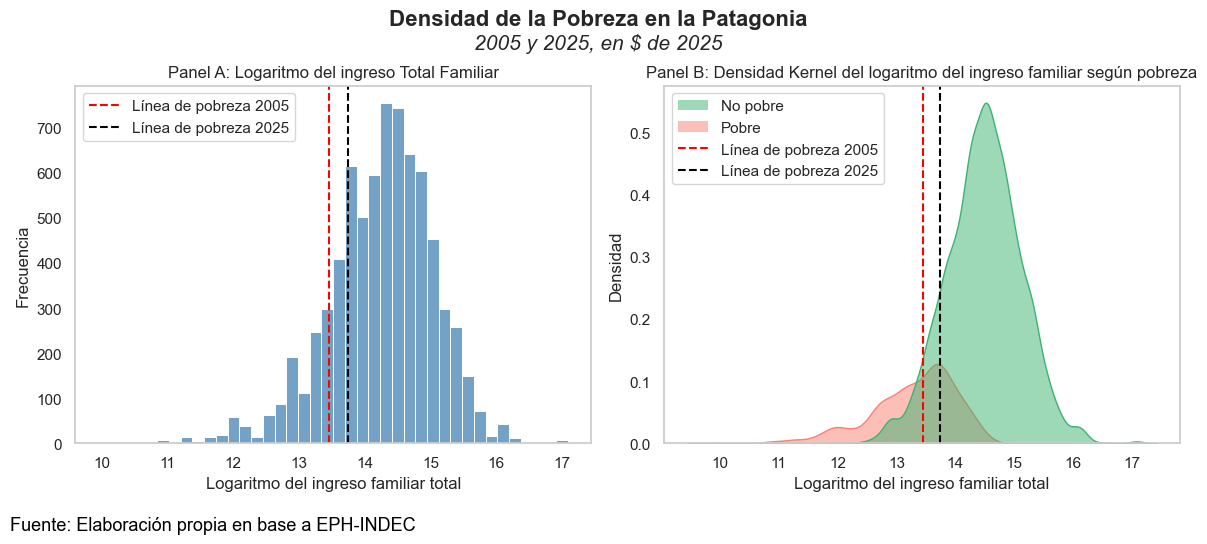

In [1504]:
# --- valores de línea de pobreza por año (usá median para ser robusto) ---
lp_2005 = eph.loc[eph['ano4']==2005, 'linea_pobreza'].median()
lp_2025 = eph.loc[eph['ano4']==2025, 'linea_pobreza'].median()

# Transformación log usada en los ejes
lp2005_log = np.log1p(lp_2005)
lp2025_log = np.log1p(lp_2025)

fig=plt.figure(figsize=(12,5))

# ===================== Panel A: Histograma =====================
ax1 = plt.subplot(1,2,1)
sns.histplot(np.log1p(eph["itf_2025"]), bins=40, color="steelblue", kde=False, ax=ax1)
ax1.set_title("Panel A: Logaritmo del ingreso Total Familiar")
ax1.set_xlabel("Logaritmo del ingreso familiar total")
ax1.set_ylabel("Frecuencia")
ax1.grid(False)

# Líneas de pobreza (2005 y 2025)
ax1.axvline(lp2005_log, color="red",   ls="--", lw=1.5, label="Línea de pobreza 2005")
ax1.axvline(lp2025_log, color="black", ls="--", lw=1.5, label="Línea de pobreza 2025")
ax1.legend(loc="upper left")

# ===================== Panel B: Kernel por pobreza =====================
ax2 = plt.subplot(1,2,2)
sns.kdeplot(
    data=eph,
    x=np.log1p(eph["itf_2025"]),
    hue="pobre",
    fill=True,
    palette={0:"mediumseagreen", 1:"salmon"},
    alpha=0.5,
    ax=ax2
)

# Líneas de pobreza (2005 y 2025)
ax2.axvline(lp2005_log, color="red",   ls="--", lw=1.5)
ax2.axvline(lp2025_log, color="black", ls="--", lw=1.5)

ax2.set_title("Panel B: Densidad Kernel del logaritmo del ingreso familiar según pobreza")
ax2.set_xlabel("Logaritmo del ingreso familiar total")
ax2.set_ylabel("Densidad")
ax2.grid(False)

# Leyenda combinada (grupos + líneas)
legend_elements = [
    Patch(facecolor="mediumseagreen", edgecolor="none", alpha=0.5, label="No pobre"),
    Patch(facecolor="salmon", edgecolor="none", alpha=0.5, label="Pobre"),
    plt.Line2D([0], [0], color='red',   lw=1.5, ls='--', label='Línea de pobreza 2005'),
    plt.Line2D([0], [0], color='black', lw=1.5, ls='--', label='Línea de pobreza 2025')
]
ax2.legend(handles=legend_elements, loc="upper left")
plt.suptitle('Densidad de la Pobreza en la Patagonia',fontsize=16, fontweight='bold', y=1.0)
plt.figtext(0.5, 0.92, '2005 y 2025, en $ de 2025',ha='center', fontsize=15, style='italic')
plt.tight_layout()
fig.text(0.01, -0.05, 'Fuente: Elaboración propia en base a EPH-INDEC', ha='left', va='bottom', fontsize=13, color='black')


fig.savefig("histograma y kernel de ingresos.png", dpi=300, bbox_inches="tight")

plt.show()

## 4) Crear la variable horastrab

In [1395]:
eph_2025.columns = eph_2025.columns.str.lower()

In [1396]:
#Tatamiento de codusu para poder hacer el merge posterior

def norm_key_str(s):
    return (s.astype(str)
             .str.normalize('NFKC')
             .str.replace('\u00a0',' ', regex=False)  # NBSP
             .str.replace(r'\.0$', '', regex=True)     # quita .0 final (p.ej., 125814.0)
             .str.strip())


eph_2025_control = eph_2025_hogar.copy()

# Normalizar
cols = ['codusu', 'nro_hogar'] 
for c in cols:
    eph_2025_control[f'{c}_key'] = norm_key_str(eph_2025_control[c])

# Reemplazar las originales con las versiones *_key
for c in cols:
    eph_2025_control[c] = eph_2025_control[f'{c}_key']

# Eliminar las columnas *_key (ya no se necesitan)
eph_2025_hogar = eph_2025_control.drop(columns=[f'{c}_key' for c in cols])

In [1397]:
#Agrego las variables necesarias para este análisis: PP3E_TOT, PP3F_TOT, CH03

variables_interes = ['pp3e_tot','pp3f_tot','ch03','ano4','codusu', 'nro_hogar', 'componente']

eph_2025_sub2 = eph_2025[variables_interes]
eph_2005_sub2 = eph_2005[variables_interes]

eph_concatenado = (pd.concat([eph_2005_sub2, eph_2025_sub2], ignore_index=True))


eph = eph.merge(eph_concatenado, on=['ano4','codusu', 'nro_hogar', 'componente'], how='left')

eph.sample(15)

,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,ch10,ch12,ch13,ch14,educ,itf_2025,linea_pobreza,pp3e_tot,pp3f_tot,ch03
1536,1.00,2005,269756,1.00,Varón,44,Casado,Obra social (incluye PAMI),Secundaria Completa,Ocupado,Obrero o empleado,NaN,"1,800.00",600.00,Sí,...un sólo empleo/ocupación/actividad?,600.00,600.00,No,30 a 45 años,1.00,2.46,504.47,0,1936,2,4,1,<NA>,13.00,"1,889,083.59","529,438.97",48.00,0.00,Jefe
2579,3.00,2005,161512,1.00,Varón,0,Soltero,Obra social (incluye PAMI),Sin instrucción,Menor de 10 años,NaN,Menor de 6 años,"2,000.00",666.67,NaN,NaN,0.00,0.00,NaN,0 años,0.35,2.13,436.80,0,0,0,0,0,<NA>,0.00,"2,098,981.76","458,416.67",0.00,0.00,Hijo/Hijastro
2617,3.00,2005,170051,1.00,Varón,4,Soltero,Obra social (incluye PAMI),Sin instrucción,Menor de 10 años,NaN,Menor de 6 años,"1,876.00",625.33,NaN,NaN,0.00,0.00,NaN,4 años,0.55,2.32,475.76,0,16,2,0,2,0.00,NaN,"1,968,844.89","499,308.30",0.00,0.00,Hijo/Hijastro
5780,1.00,2025,TQRMNOPXVHJNLLCDEGNFJ00877067,1.00,Mujer,38,Unido,Obra social (incluye PAMI),Superior Universitaria Incompleta,Ocupado,Obrero o empleado,NaN,"2,200,000.00","366,666.67",Sí,...un sólo empleo/ocupación/actividad?,"1,200,000.00","900,000.00",Sí,30 a 45 años,0.77,5.49,"2,004,821.73",0,1444,1,7,2,1.00,14.00,"2,200,000.00","2,004,821.73",35.00,0.00,1
799,1.00,2005,281122,1.00,Mujer,58,Soltero,No paga ni le descuentan,Primaria Completa,Ocupado,Obrero o empleado,NaN,750.00,375.00,No,...un sólo empleo/ocupación/actividad?,750.00,750.00,No,46 a 60 años,0.76,1.53,313.76,0,3364,2,1,1,<NA>,1.00,"787,118.16","329,285.22",44.00,0.00,Jefe
5289,2.00,2025,TQRMNORTUHLMKNCDEOJAH00856257,1.00,Mujer,27,Unido,Obra social (incluye PAMI),Superior Universitaria Completa,Ocupado,Obrero o empleado,NaN,"3,150,000.00","1,575,000.00",Sí,...un sólo empleo/ocupación/actividad?,"1,650,000.00","1,100,000.00",No,18 a 29 años,0.76,1.52,"555,069.04",0,729,2,7,1,<NA>,19.00,"3,150,000.00","555,069.04",48.00,0.00,2
5992,1.00,2025,TQRMNOSQRHMNKUCDEGNFJ00880844,1.00,Varón,38,Soltero,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,Obrero o empleado,NaN,"320,000.00","320,000.00",Sí,...un sólo empleo/ocupación/actividad?,"320,000.00","320,000.00",No,30 a 45 años,1.00,1.00,"365,177.00",1,1444,2,4,2,2.00,10.00,"320,000.00","365,177.00",20.00,0.00,1
4304,4.00,2025,TQRMNOPXXHJLLMCDEGNFJ00874588,1.00,Varón,26,Casado,No paga ni le descuentan,Superior Universitaria Incompleta,Inactivo,NaN,Estudiante,"1,000,000.00","250,000.00",NaN,NaN,0.00,0.00,NaN,18 a 29 años,1.02,3.54,"1,292,726.58",1,676,1,7,2,4.00,17.00,"1,000,000.00","1,292,726.58",NaN,NaN,3
3943,3.00,2025,TQRMNORSRHKOLQCDEGNFJ00859433,1.00,Mujer,46,Unido,Obra social (incluye PAMI),Secundaria Completa,Inactivo,NaN,Ama de casa,"970,000.00","323,333.33",NaN,NaN,"270,000.00",0.00,NaN,46 a 60 años,0.76,2.43,"887,380.11",0,2116,2,4,1,<NA>,13.00,"970,000.00","887,380.11",NaN,NaN,2
712,7.00,2005,261490,1.00,Varón,2,Soltero,Obra social (incluye PAMI),Sin instrucción,Menor de 10 años,NaN,Menor de 6 años,945.00,94.50,NaN,NaN,0.00,0.00,NaN,2 años,0.46,6.97,"1,429.34",1,4,3,0,0,<NA>,0.00,"991,768.88","1,500,077.09",0.00,0.00,Hijo/Hijastro


In [1398]:
# Es necesario normalizar ch03 que como en el tp1, la eph de 2005 tiene categorías en palabras
eph["ch03"].unique()

array(['Jefe', 'Cónyuge/Pareja', 'Hijo/Hijastro', 'No familiares',
       'Yerno/Nuera', 'Nieto', 'Otros familiares', 'Madre/Padre',
       'Hermano', 'Suegro', 1, 3, 2, 4, 10, 5, 8, 6, 9, 7], dtype=object)

In [1399]:
# Es necesario normalizar ch03 que como en el tp1, la eph de 2005 tiene categorías en palabras

def parentesco(ch03):
    if ch03 == 'Jefe':
        return 1
    elif ch03 == 'Cónyuge/Pareja':
        return 2
    elif ch03 == 'Hijo/Hijastro':
        return 3
    elif ch03 == 'Yerno/Nuera':
        return 4
    elif ch03 == "Nieto":
        return 5
    elif ch03 == "Madre/Padre":
        return 6
    elif ch03 == "Suegro":
        return 7
    elif ch03 == 'Hermano':
        return 8
    elif ch03 == 'Otros familiares':
        return 9
    elif ch03 == 'No familiares':
        return 10
    else:
        return ch03

eph['ch03'] = eph['ch03'].apply(parentesco)

eph["ch03"].unique()

array([ 1,  2,  3, 10,  4,  5,  9,  6,  8,  7], dtype=int64)

In [1400]:
# Ya con las variables necesarias normalizadas hacemos el calculo de horastrab

eph["horastrab"] = np.where(eph["ch03"] == 1,eph["pp3e_tot"] + eph["pp3f_tot"],np.nan )

eph[['ch03',"pp3e_tot","pp3f_tot", 'horastrab']].head(10)

,ch03,pp3e_tot,pp3f_tot,horastrab
0,1,48.00,0.00,48.00
1,2,0.00,0.00,NaN
2,3,0.00,0.00,NaN
3,3,0.00,0.00,NaN
4,3,0.00,0.00,NaN
5,1,24.00,0.00,24.00
6,2,0.00,0.00,NaN
7,1,28.00,0.00,28.00
8,1,48.00,0.00,48.00
9,2,0.00,0.00,NaN


In [1401]:
cols_horas = [c for c in eph.columns if "pp3" in c and "tot" in c]
print("Columnas candidatas a horas trabajadas:", cols_horas)

if "pp3e_tot" in eph.columns and "pp3f_tot" in eph.columns:
    eph["horastrab"] = eph["pp3e_tot"].fillna(0) + eph["pp3f_tot"].fillna(0)
else:
    eph["horastrab"] = np.nan


eph["horastrab"].describe()



Columnas candidatas a horas trabajadas: ['pp3e_tot', 'pp3f_tot']


count   7,340.00
mean       16.07
std        25.43
min         0.00
25%         0.00
50%         0.00
75%        35.00
max     1,014.00
Name: horastrab, dtype: float64

In [1429]:
# === Descriptivos básicos ===
#Elimino valores superiores a 84 (12 horas los 7 días de la semana) porque ya no sería razonable
eph.loc[eph["horastrab"] > 84, "horastrab"] = np.nan

eph.loc[eph["estado"] == "Ocupado"]["horastrab"].describe()

count   3,046.00
mean       37.45
std        18.65
min         0.00
25%        30.00
50%        40.00
75%        48.00
max        84.00
Name: horastrab, dtype: float64

In [1425]:
eph.loc[eph["estado"] == "Ocupado"].groupby("ano4")["horastrab"].describe()

,count,mean,std,min,25%,50%,75%,max
ano4,,,,,,,,
2005,"1,251.00",38.72,20.91,0.00,25.00,40.00,52.00,84.00
2025,"1,795.00",36.57,16.85,0.00,30.00,40.00,48.00,84.00


## 5) Tabla resumen por año

In [1405]:

resumen = {
    "Año": [],
    "Cantidad observaciones": [],
    "Observaciones con NA en 'pobre'": [],
    "Cantidad de Pobres": [],
    "Cantidad de No Pobres": [],
    "Cantidad de variables limpias y homogenizadas": []
}


for anio in [2005,2025]:
    df_anio = eph.loc[eph["ano4"] == anio]

    resumen["Año"].append(anio)
    resumen["Cantidad observaciones"].append(len(df_anio))
    resumen["Observaciones con NA en 'pobre'"].append(df_anio["pobre"].isna().sum())
    resumen["Cantidad de Pobres"].append((df_anio["pobre"] == 1).sum())
    resumen["Cantidad de No Pobres"].append((df_anio["pobre"] == 0).sum())
    resumen["Cantidad de variables limpias y homogenizadas"].append(df_anio.shape[1])

resumen["Año"].append("Total")
resumen["Cantidad observaciones"].append(len(eph))
resumen["Observaciones con NA en 'pobre'"].append(eph["pobre"].isna().sum())
resumen["Cantidad de Pobres"].append((eph["pobre"] == 1).sum())
resumen["Cantidad de No Pobres"].append((eph["pobre"] == 0).sum())
resumen["Cantidad de variables limpias y homogenizadas"].append(eph.shape[1])

tabla_resumen = pd.DataFrame(resumen)
tabla_resumen.set_index("Año", inplace=True)

print("Resumen de la base final para la región Patagónica\n")
print(tabla_resumen_T)

Resumen de la base final para la región Patagónica

Año                                            2005  2025  Total
Cantidad observaciones                         3206  4134   7340
Observaciones con NA en 'pobre'                   0     0      0
Cantidad de Pobres                              575   850   1425
Cantidad de No Pobres                          2631  3284   5915
Cantidad de variables limpias y homogenizadas    35    35     35


# Parte II: Métodos no supervisados

In [1407]:
#Primero descargamos la EPH de hogares de 2025 y 2005 para obtener ix_tot

#EPH 2025

url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_1_Trim_2025_xls.zip"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Listar los archivos contenidos
    print(z.namelist())
    
    # Abrir el Excel
    with z.open("EPH_usu_1er_Trim_2025_xlsx/usu_hogar_T125.xlsx") as f:
        eph_2025_hogar = pd.read_excel(f)

eph_2025_hogar.columns = eph_2025_hogar.columns.str.lower()

['EPH_usu_1er_Trim_2025_xlsx/', 'EPH_usu_1er_Trim_2025_xlsx/usu_hogar_T125.xlsx', 'EPH_usu_1er_Trim_2025_xlsx/usu_individual_T125.xlsx']


In [1408]:
eph_2025_hogar.loc[eph_2025_hogar['codusu'] == 'TQRMNOPUPHMMKOCDEIHJF00880517']

,codusu,ano4,trimestre,nro_hogar,realizada,region,mas_500,aglomerado,pondera,iv1,iv1_esp,iv2,iv3,iv3_esp,iv4,iv5,iv6,iv7,iv7_esp,iv8,iv9,iv10,iv11,iv12_1,iv12_2,iv12_3,ii1,ii2,ii3,ii3_1,ii4_1,ii4_2,ii4_3,ii5,ii5_1,ii6,ii6_1,ii7,ii7_esp,ii8,ii8_esp,ii9,v1,v2,v2_02,v2_03,v21_01,v22_01,v3,v4,v5_02,v5_03,v6,v7,v8,v9,v10,v11_01,v11_02,v12,v13,v14,v15,v16,v17,v18,v19_a,v19_b,ix_tot,ix_men10,ix_mayeq10,itf,decifr,idecifr,rdecifr,gdecifr,pdecifr,adecifr,ipcf,deccfr,ideccfr,rdeccfr,gdeccfr,pdeccfr,adeccfr,pondih,vii1_1,vii1_2,vii2_1,vii2_2,vii2_3,vii2_4,v5_01,v21_02,v21_03,v22_02,v22_03,v2_01
4417,TQRMNOPUPHMMKOCDEIHJF00880517,2025,1,1,1,44,N,31,123,2,NaN,2,1,NaN,4,1,1,1,NaN,1,1,1,1,2,2,2,2,1,2,0,2,2,2,0,0,0,0,3,NaN,1,NaN,1,1,2,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,1,1,2,2,2,2,2,0,2,1700000,7,8.00,6,NaN,8.00,6,"850,000.00",8,8.00,7,NaN,9.00,6,123,1,0,2,0,0,0,2,2,2,2,2,0


In [1409]:
#EPH 2005


# Lo mismo para la EPH 2005
url = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/t105_dta.zip"

# Descargar el ZIP
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Mostrar los archivos contenidos
    print(z.namelist())

    # Abrir el archivo .dta directamente desde el ZIP
    with z.open("Hogar_t105.dta") as f:
        eph_2005_hogar = pd.read_stata(f)

eph_2005_hogar.columns = eph_2005_hogar.columns.str.lower()

['Hogar_t105.dta', 'Individual_t105.dta', 'T105.txt']


In [1410]:
#Tatamiento de codusu para poder hacer el merge posterior

def norm_key_str(s):
    return (s.astype(str)
             .str.normalize('NFKC')
             .str.replace('\u00a0',' ', regex=False)  # NBSP
             .str.replace(r'\.0$', '', regex=True)     # quita .0 final (p.ej., 125814.0)
             .str.strip())


eph_2005_control = eph_2005_hogar.copy()

# Normalizar
cols = ['codusu', 'nro_hogar'] 
for c in cols:
    eph_2005_control[f'{c}_key'] = norm_key_str(eph_2005_control[c])

# Reemplazar las originales con las versiones *_key
for c in cols:
    eph_2005_control[c] = eph_2005_control[f'{c}_key']

# Eliminar las columnas *_key (ya no se necesitan)
eph_2005_hogar = eph_2005_control.drop(columns=[f'{c}_key' for c in cols])


In [1411]:
#Tatamiento de codusu para poder hacer el merge posterior

def norm_key_str(s):
    return (s.astype(str)
             .str.normalize('NFKC')
             .str.replace('\u00a0',' ', regex=False)  # NBSP
             .str.replace(r'\.0$', '', regex=True)     # quita .0 final (p.ej., 125814.0)
             .str.strip())


eph_2025_control = eph_2025_hogar.copy()

# Normalizar
cols = ['codusu', 'nro_hogar'] 
for c in cols:
    eph_2025_control[f'{c}_key'] = norm_key_str(eph_2025_control[c])

# Reemplazar las originales con las versiones *_key
for c in cols:
    eph_2025_control[c] = eph_2025_control[f'{c}_key']

# Eliminar las columnas *_key (ya no se necesitan)
eph_2025_hogar = eph_2025_control.drop(columns=[f'{c}_key' for c in cols])

In [1412]:
#Traemos la variable IX_TOT de las bases originales

bases = [eph, eph_2005_hogar,eph_2025_hogar]

# Convertir nro_hogar a float en cada una
for df in bases:
    df['nro_hogar'] = df['nro_hogar'].astype(int)
    df["codusu"] = df["codusu"].astype(str).str.strip()

variables_interes = ['ix_tot','ano4','codusu', 'nro_hogar']

eph_2025_sub3 = eph_2025_hogar[variables_interes]
eph_2005_sub3 = eph_2005_hogar[variables_interes]

eph_concatenado = (pd.concat([eph_2025_sub3,eph_2005_sub3], ignore_index=True))

eph = eph.merge(eph_concatenado, on=['ano4','codusu', 'nro_hogar'], how='left')

eph.sample(10)

,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,ch10,ch12,ch13,ch14,educ,itf_2025,linea_pobreza,pp3e_tot,pp3f_tot,ch03,horastrab,ix_tot
3646,1.00,2025,TQRMNOQQUHLNLNCDEOJAH00856301,1,Mujer,71,Viudo,Obra social (incluye PAMI),Primaria Completa,Inactivo,NaN,Jubilado/pensionado,"600,000.00","600,000.00",NaN,NaN,"600,000.00",0.00,NaN,61 a 75 años,0.67,0.67,"244,668.59",0,5041,2,2,1,<NA>,8.00,"600,000.00","244,668.59",NaN,NaN,1,0.00,1.00
6409,1.00,2025,TQRMNOSYWHLNLLCDEFPCH00872996,1,Mujer,38,Soltero,Obra social (incluye PAMI),Superior Universitaria Completa,Ocupado,Obrero o empleado,NaN,"1,125,000.00","1,125,000.00",Sí,...un sólo empleo/ocupación/actividad?,"1,125,000.00","750,000.00",No,30 a 45 años,0.77,0.77,"281,186.29",0,1444,2,6,1,<NA>,16.00,"1,125,000.00","281,186.29",48.00,0.00,1,48.00,1.00
7312,1.00,2025,TQRMNOPTVHKNKPCDEIHJF00858945,1,Mujer,34,Soltero,Planes y seguros públicos,Superior Universitaria Incompleta,Desocupado,Obrero o empleado,NaN,"140,000.00","140,000.00",NaN,NaN,"140,000.00",0.00,NaN,30 a 45 años,0.77,0.77,"281,186.29",1,1156,1,7,2,3.00,16.00,"140,000.00","281,186.29",NaN,NaN,1,0.00,1.00
2537,3.00,2005,152909,1,Mujer,13,Soltero,Obra social (incluye PAMI),Secundaria Incompleta,Inactivo,NaN,Estudiante,"1,350.00",337.50,NaN,NaN,0.00,0.00,NaN,13 años,0.76,3.22,660.33,0,169,1,3,2,9.00,NaN,"1,416,812.69","693,005.49",0.00,0.00,3,0.00,4.00
2296,1.00,2005,261108,1,Mujer,48,Soltero,Obra social (incluye PAMI),Primaria Completa,Ocupado,Obrero o empleado,NaN,"1,250.00",178.57,Sí,...un sólo empleo/ocupación/actividad?,"1,100.00",800.00,No,46 a 60 años,0.76,4.65,953.58,0,2304,2,1,1,<NA>,1.00,"1,311,863.60","1,000,768.79",35.00,0.00,1,35.00,7.00
4442,1.00,2025,TQRMNOQPTHMMLOCDEGNFJ00878980,1,Mujer,76,Separado o divorciado,Obra social (incluye PAMI),Superior Universitaria Completa,Inactivo,NaN,Jubilado/pensionado,"800,000.00","800,000.00",NaN,NaN,"800,000.00",0.00,NaN,más de 75 años,0.63,0.63,"230,061.51",0,5776,2,6,1,<NA>,16.00,"800,000.00","230,061.51",NaN,NaN,1,0.00,1.00
1507,3.00,2005,259957,1,Varón,28,Soltero,Obra social (incluye PAMI),Superior Universitaria Incompleta,Ocupado,Obrero o empleado,NaN,"2,900.00",966.67,Sí,NaN,400.00,400.00,No,18 a 29 años,1.02,2.78,570.09,0,784,1,7,2,0.00,13.00,"3,043,523.55","598,309.08",0.00,0.00,3,0.00,3.00
1974,2.00,2005,198004,1,Mujer,46,Unido,Obra social (incluye PAMI),Secundaria Completa,Ocupado,Obrero o empleado,NaN,"4,700.00","1,175.00",Sí,...un sólo empleo/ocupación/actividad?,700.00,700.00,No,46 a 60 años,0.76,3.33,682.88,0,2116,2,4,1,<NA>,13.00,"4,932,607.14","716,679.59",48.00,0.00,2,48.00,4.00
5360,2.00,2025,TQRMNOWYSHLMLPCDEOHCH00859245,1,Mujer,18,Soltero,Mutual/Prepaga/Servicio de emergencia,Secundaria Incompleta,Inactivo,NaN,Estudiante,"2,000,000.00","1,000,000.00",NaN,NaN,0.00,0.00,NaN,18 a 29 años,0.76,1.76,"642,711.52",0,324,1,4,2,3.00,11.00,"2,000,000.00","642,711.52",NaN,NaN,3,0.00,2.00
5388,1.00,2025,TQRMNOSQTHLOLMCDEGNFJ00853346,2,Varón,22,Soltero,Obra social (incluye PAMI),Secundaria Completa,Ocupado,Obrero o empleado,NaN,"1,000,000.00","1,000,000.00",Sí,...un sólo empleo/ocupación/actividad?,"1,000,000.00","1,000,000.00",No,18 a 29 años,1.02,1.02,"372,480.54",0,484,2,4,1,<NA>,13.00,"1,000,000.00","372,480.54",48.00,0.00,1,48.00,1.00


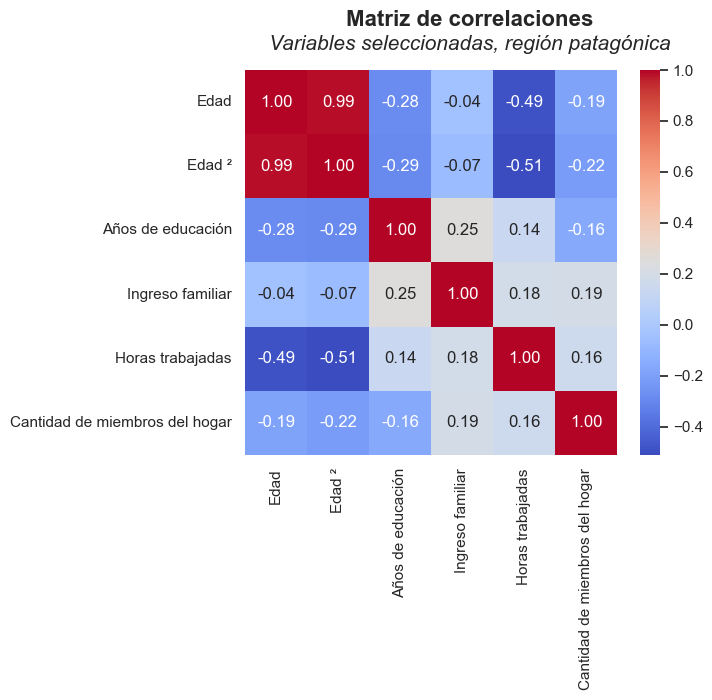

In [1506]:
# === Matriz de correlaciones ===

#Me quedo solo con los jefedes de hogar ya que horastrab tiene NaN cuando no son jefes por como la construimos en el ejercicio anterior.
eph_jefes = eph.loc[eph['ch03'] == 1].copy()   

# Eliminar filas con NaN en alguna de las variables de interés
eph_jefes = eph_jefes.dropna(subset=vars_corr)

nombres_vars = {
    "ch06": "Edad",
    "edad2": "Edad ²",
    "educ": "Años de educación",
    "itf_2025": "Ingreso familiar",
    "horastrab": "Horas trabajadas",
    "ix_tot": "Cantidad de miembros del hogar"
}


vars_corr = ["ch06","edad2","educ","itf_2025","horastrab",'ix_tot']
corr = eph_jefes[vars_corr].corr()

corr.rename(index=nombres_vars, columns=nombres_vars, inplace=True)

fig = plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.suptitle('Matriz de correlaciones',fontsize=16, fontweight='bold', y=1.0)
plt.figtext(0.5, 0.92, 'Variables seleccionadas, región patagónica',ha='center', fontsize=15, style='italic')
plt.grid(False)
fig.savefig("correlaciones.png", dpi=300, bbox_inches="tight")
plt.show()

## A. PCA

## PCA con ingreso

Cantidad de filas con datos completos: 7198


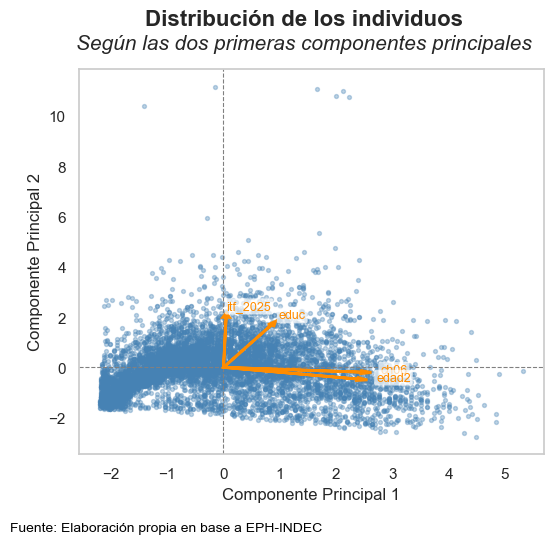

In [1508]:
# === PCA ===

# Variables sin tantos faltantes
vars_pca = ["ch06","edad2","educ","itf_2025"]

# Verificamos cuántas filas completas hay
print("Cantidad de filas con datos completos:", eph[vars_pca].dropna().shape[0])

# Eliminamos filas con NaN solo en estas columnas
X = eph[vars_pca].dropna()

# Escalamos las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajustamos PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)


#Calcular loadings escalados
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

#
scores = X_pca[:, :2]                               
L = pca.components_.T[:, :2] * np.sqrt(pca.explained_variance_[:2]) 

# Factor de escala automático: que las flechas ocupen ~35% del rango de cada eje
xr = scores[:,0].max() - scores[:,0].min()
yr = scores[:,1].max() - scores[:,1].min()
fx = 0.35 * xr / (np.abs(L[:,0]).max() + 1e-9)
fy = 0.35 * yr / (np.abs(L[:,1]).max() + 1e-9)
scale = min(fx, fy)

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(scores[:,0], scores[:,1], s=8, alpha=0.35, color='steelblue')
ax.axhline(0, color='gray', ls='--', lw=0.8); ax.axvline(0, color='gray', ls='--', lw=0.8)
ax.set_xlabel("Componente Principal 1"); ax.set_ylabel("Componente Principal 2")
plt.suptitle('Distribución de los individuos',fontsize=16, fontweight='bold', y=1.0)
plt.figtext(0.5, 0.92, 'Según las dos primeras componentes principales',ha='center', fontsize=15, style='italic')
# Flechas visiblemente grandes
for i, var in enumerate(vars_pca):
    x, y = scale*L[i,0], scale*L[i,1]
    ax.arrow(0, 0, x, y, color='darkorange', lw=2.0,
             head_width=0.12, length_includes_head=True, zorder=5)
    ax.text(x*1.06, y*1.06, var, color='darkorange', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.7), zorder=6)
plt.grid(False)
fig.text(0.01, -0.05, 'Fuente: Elaboración propia en base a EPH-INDEC', ha='left', va='bottom', fontsize=10, color='black')

fig.savefig("gráfico cp.png", dpi=300, bbox_inches="tight")



plt.show()

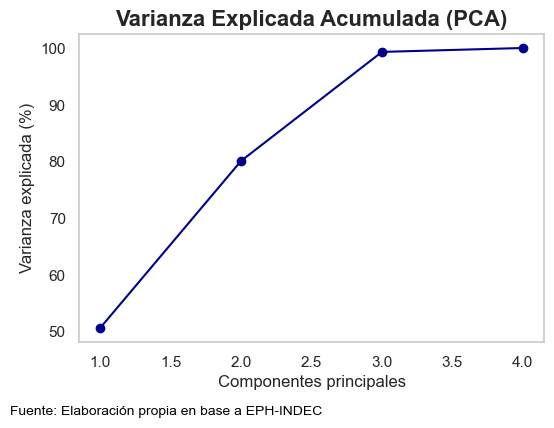

In [1510]:
# Scree Plot
fig=plt.figure(figsize=(6,4))
plt.plot(range(1,5), np.cumsum(pca.explained_variance_ratio_)*100, marker='o', color='darkblue')
plt.title("Varianza Explicada Acumulada (PCA)",fontsize=16, fontweight='bold')
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada (%)")
plt.grid(True)
plt.grid(False)
fig.savefig("varianza acumulada.png", dpi=300, bbox_inches="tight")
fig.text(0.01, -0.08, 'Fuente: Elaboración propia en base a EPH-INDEC', ha='left', va='bottom', fontsize=10, color='black')

plt.show()


In [1419]:
# === Loadings de PCA (ajustado a 4 variables) ===
loadings = pd.DataFrame(
    pca.components_.T,
    index=vars_pca,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print("Cargas (loadings) de las variables en los componentes principales:\n")
display(loadings.round(3))

Cargas (loadings) de las variables en los componentes principales:



,PC1,PC2,PC3,PC4
ch06,0.69,-0.07,-0.06,0.71
edad2,0.68,-0.17,-0.19,-0.69
educ,0.24,0.64,0.72,-0.11
itf_2025,0.01,0.75,-0.66,0.01


## B. Cluster

## Cluster k-medias

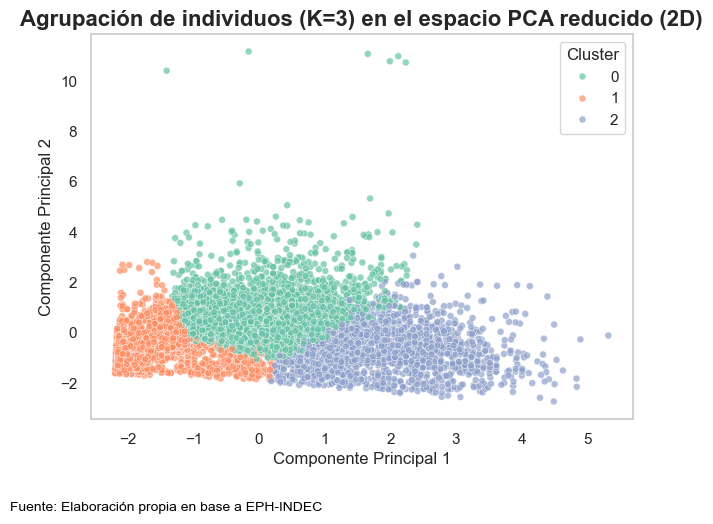

In [1512]:
# ===  K-Means (con las mismas 4 variables del PCA) ===
from sklearn.cluster import KMeans

# Usamos las mismas variables que en el PCA
X = eph[["ch06","edad2","educ","itf_2025"]].dropna()

# Escalamos nuevamente (igual que en el PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajustamos K-Means para distintos k
kmeans_results = {}
for k in [2, 3, 4]:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    eph[f"cluster_{k}"] = np.nan
    eph.loc[X.index, f"cluster_{k}"] = labels
    kmeans_results[k] = kmeans.inertia_

# Visualización para k=3 (ejemplo principal)
pca_plot = PCA(n_components=2)
coords = pca_plot.fit_transform(X_scaled)

fig=plt.figure(figsize=(7,5))
sns.scatterplot(x=coords[:,0], y=coords[:,1],
                hue=eph.loc[X.index,"cluster_3"].astype(int),
                palette="Set2", s=25, alpha=0.7)
plt.title("Agrupación de individuos (K=3) en el espacio PCA reducido (2D)", fontsize=16, fontweight='bold')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(False)
fig.text(0.01, -0.08, 'Fuente: Elaboración propia en base a EPH-INDEC', ha='left', va='bottom', fontsize=10, color='black')
fig.savefig("clusters.png", dpi=300, bbox_inches="tight")
plt.show()

## Método del codo

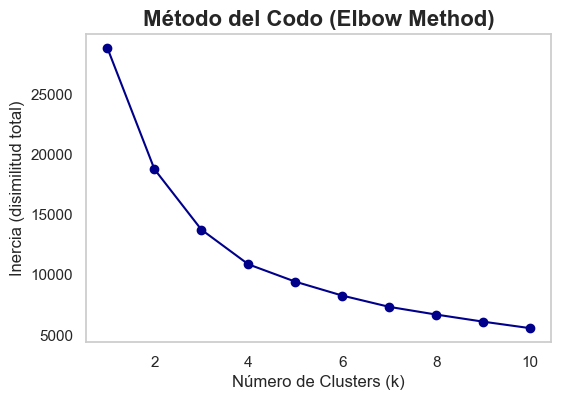

In [1514]:
# === Método del Codo ===
ks = range(1, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

fig=plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o', color='darkblue')
plt.title("Método del Codo (Elbow Method)", fontsize=16, fontweight='bold')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inercia (disimilitud total)")
plt.grid(True)
plt.grid(False)
fig.savefig("Método del codo.png", dpi=300, bbox_inches="tight")
plt.show()

## Cluster jerárquico

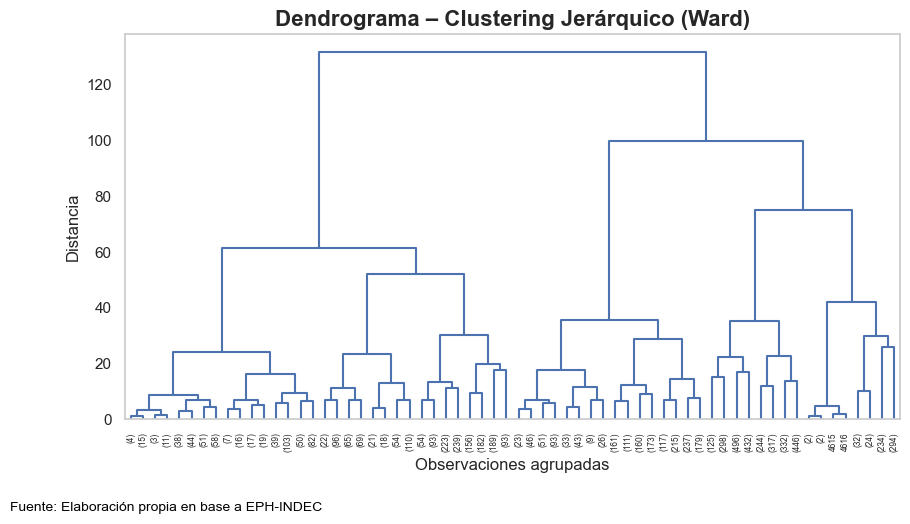

In [1516]:
# === Clustering jerárquico ===
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_scaled, method='ward')

fig=plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode='level', p=5, color_threshold=0)
plt.title("Dendrograma – Clustering Jerárquico (Ward)", fontsize=16, fontweight='bold')
plt.xlabel("Observaciones agrupadas")
plt.ylabel("Distancia")
plt.grid(False)
fig.text(0.01, -0.08, 'Fuente: Elaboración propia en base a EPH-INDEC', ha='left', va='bottom', fontsize=10, color='black')
fig.savefig("dendgrama.png", dpi=300, bbox_inches="tight")
plt.show()